In [43]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from rasterio.mask import mask
from shapely.geometry import mapping


In [45]:
# Load the Phoenix subdivision shapefile
phoenix_shapefile = gpd.read_file("data/phoenix_subdivision.shp")

# Load the BII rasters (2017 and 2020)
bii_2017_path = "data/bii_2017_34.74464974521749_-115.38597824385106_cog.tif"
bii_2020_path = "data/bii_2020_34.74464974521749_-115.38597824385106_cog.tif"

# Open the 2017 BII raster
with rasterio.open(bii_2017_path) as src_2017:
    bii_2017_data = src_2017.read(1)  # Read the first band 
    bii_2017_meta = src_2017.meta  # Metadata for the raster

# Open the 2020 BII raster
with rasterio.open(bii_2020_path) as src_2020:
    bii_2020_data = src_2020.read(1)
    bii_2020_meta = src_2020.meta


In [73]:
# Open the raster file 
with rasterio.open(bii_2017_path) as src:
    raster_crs = src.crs  # Get CRS from the raster file
    print(f"CRS of 2017 BII raster: {raster_crs}")
with rasterio.open(bii_2020_path) as src:
    raster_crs = src.crs  # Get CRS from the raster file
    print(f"CRS of 2017 BII raster: {raster_crs}")

CRS of 2017 BII raster: EPSG:4326
CRS of 2017 BII raster: EPSG:4326


In [74]:
shapefile_crs = phoenix_shapefile.crs
print(f"CRS of Phoenix shapefile: {shapefile_crs}")

# Reproject shapefile CRS to match raster CRS (EPSG:4326)
if shapefile_crs != 'EPSG:4326':
    phoenix_shapefile = phoenix_shapefile.to_crs(epsg=4326)
    print(f"Reprojected shapefile CRS to: EPSG:4326")

CRS of Phoenix shapefile: EPSG:4326


In [69]:
# Convert Phoenix shapefile geometry to mask format
phoenix_geometry = phoenix_shapefile.geometry.values[0]

# Clip the BII data for both 2017 and 2020 rasters
def clip_raster_with_shapefile(raster_data, raster_meta, geometry):
    with rasterio.open(raster_data) as src:
        out_image, out_transform = mask(src, [mapping(geometry)], crop=True)
        out_meta = src.meta
    return out_image[0], out_transform, out_meta

bii_2017_clipped, transform_2017, meta_2017 = clip_raster_with_shapefile(bii_2017_path, bii_2017_meta, phoenix_geometry)
bii_2020_clipped, transform_2020, meta_2020 = clip_raster_with_shapefile(bii_2020_path, bii_2020_meta, phoenix_geometry)


In [70]:
# Create a mask for BII ≥ 0.75 for both years
bii_2017_mask = bii_2017_clipped >= 0.75
bii_2020_mask = bii_2020_clipped >= 0.75


In [71]:
# Define the resolution (in square meters) based on raster metadata
pixel_area = abs(meta_2017['transform'][0] * meta_2017['transform'][4])  # resolution * resolution

# Calculate the total area of the Phoenix subdivision
total_area = bii_2017_mask.size * pixel_area

# Calculate the area with BII >= 0.75 for both years
area_bii_2017 = np.sum(bii_2017_mask) * pixel_area
area_bii_2020 = np.sum(bii_2020_mask) * pixel_area

# Calculate the percentage
percentage_bii_2017 = (area_bii_2017 / total_area) * 100
percentage_bii_2020 = (area_bii_2020 / total_area) * 100

print(f"Percentage of Phoenix area with BII ≥ 0.75 in 2017: {percentage_bii_2017:.2f}%")
print(f"Percentage of Phoenix area with BII ≥ 0.75 in 2020: {percentage_bii_2020:.2f}%")


Percentage of Phoenix area with BII ≥ 0.75 in 2017: 4.17%
Percentage of Phoenix area with BII ≥ 0.75 in 2020: 3.80%


(-0.5, 991.5, 583.5, -0.5)

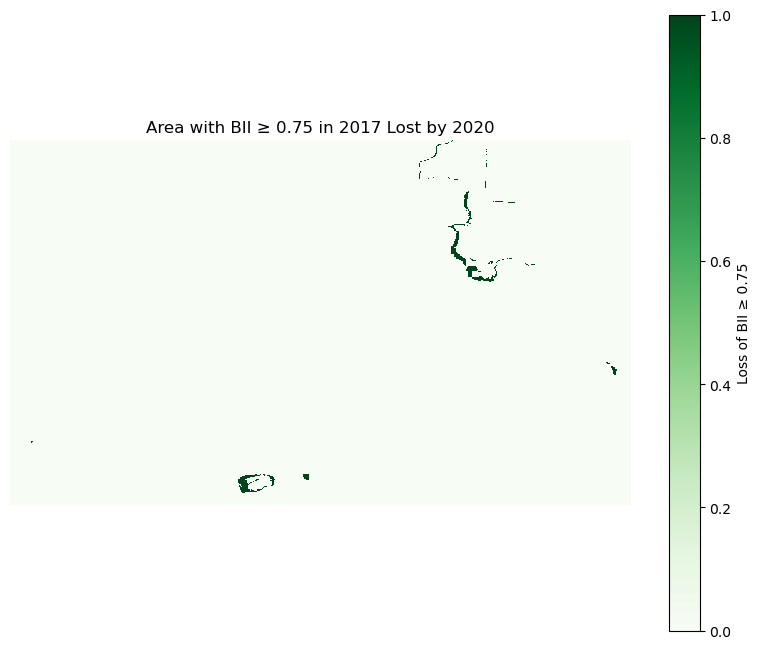

In [72]:
# Identify areas with BII ≥ 0.75 in 2017 that have lost that condition by 2020
bii_loss = (bii_2017_mask == 1) & (bii_2020_mask == 0)

# Plot the result
plt.figure(figsize=(10, 8))
plt.imshow(bii_loss, cmap='Greens', interpolation='nearest')
plt.title("Area with BII ≥ 0.75 in 2017 Lost by 2020")
plt.colorbar(label="Loss of BII ≥ 0.75")
plt.axis('off')
